## Challenge: Preparing a dataset for modeling

For this challenge, I will use data from the [Student Alcohol Consumption survey](https://www.kaggle.com/uciml/student-alcohol-consumption), which includes social, gender, and study data from secondary school students at two schools in Brazil. The data were made available on Kaggle in two csv files: one for math students and one for Portuguese language students. Let's load the data and begin exploring, getting oriented with the first few rows of the data.

In [19]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.mlab import PCA as mlabPCA

import matplotlib.ticker as mtick
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
sns.set_style("whitegrid")

por = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/student-por.csv')
mat = pd.read_csv('/Users/teresaoneill/Dropbox/Thinkful/Datasets/student-mat.csv')

In [20]:
print(len(por))
por.head()

649


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [21]:
print(len(mat))
mat.head()

395


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Exploring continuous and categorical variables

We can see that we have 33 variables; most are categorical, while there are some ordinal items related to parental level of education, commute time, study time, and past academic performance. Other scalar items related to social activities and frequency of alcohol consumption are measured on a 5-point scale and could be modeled as continuous variables. 

The two datasets include the same variables, so let's add them together, including an additional variable to track which subject they come from. Then, we will take a look at the distributions of the scalar items and relationships among them in a scatterplot matrix. 

Because of the large number of variables in this dataset, after this initial perusal, we will select a subset of variables to work with. For our ** outcome variable **, we'll use final grade (G3), which is measured on a numerical scale from 0-20. 

In [22]:
mat['subject'] = 'math'
por['subject'] = 'portuguese'
df = mat.append(por, ignore_index=True)

To get started, let's get a descriptive overview of the data, including a sense for how many missing items there are, with descriptions.

In [23]:
#Generate descriptions for each column.

for col in df.columns:
    print(df[col].describe())

count     1044
unique       2
top         GP
freq       772
Name: school, dtype: object
count     1044
unique       2
top          F
freq       591
Name: sex, dtype: object
count    1044.000000
mean       16.726054
std         1.239975
min        15.000000
25%        16.000000
50%        17.000000
75%        18.000000
max        22.000000
Name: age, dtype: float64
count     1044
unique       2
top          U
freq       759
Name: address, dtype: object
count     1044
unique       2
top        GT3
freq       738
Name: famsize, dtype: object
count     1044
unique       2
top          T
freq       923
Name: Pstatus, dtype: object
count    1044.000000
mean        2.603448
std         1.124907
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: Medu, dtype: float64
count    1044.000000
mean        2.387931
std         1.099938
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Nam

It appears that there are no missingness indicators in the dataset, so we're ready to start investigating the distribution of the different variables.

We will begin with the outcome variable, G3, and the closely associated variables corresponding to the first and second marking periods. The grid below indicates a strong linear relationship between the three grades. Since we're interested in final grades, we'll drop G1 and G2 from the later analysis: final grades are likely composed of grades from the earlier marking periods, so G1 and G2 are redundant with G3. 

The outcome variable, final grade, has a bit of a bimodal distribution, with a small secondary peak at the floor (0), but otherwise, it follows the normal distribution. In an OLS model, we'll have to keep an eye on the zeros. If they become problematic, we could consider a different model that is sensitive to this distribution.

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


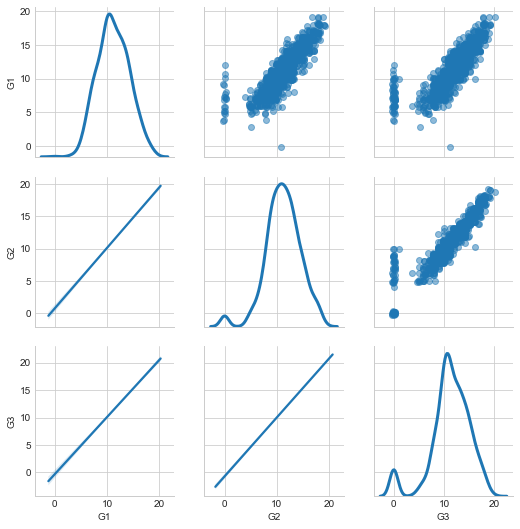

In [24]:
# Make the scatterplot matrix of the grade items.
# We'll create a dataframe of random noise (or "jitter") and add it to the plot.

# Make a copy of the data to add jitter to and plot.
df_jittered = df.loc[:, 'G1':'G3']

# Make the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)

# Combine the data and the noise.

df_jittered = df_jittered.add(jitter)
#Declare the plot and plot.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Next, we'll start visualizing the distributions. The kde plots on the diagonal in the grid below show that the 'free time' and 'go out' variables are somewhat normally distributed, while the others are not. The 'quality of family relationships' and 'health' variables are left-skewed, while 'weekday alcohol consumption' and 'weekend alcohol consumption' are right-skewed, corresponding to something like a lognormal distribution.

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


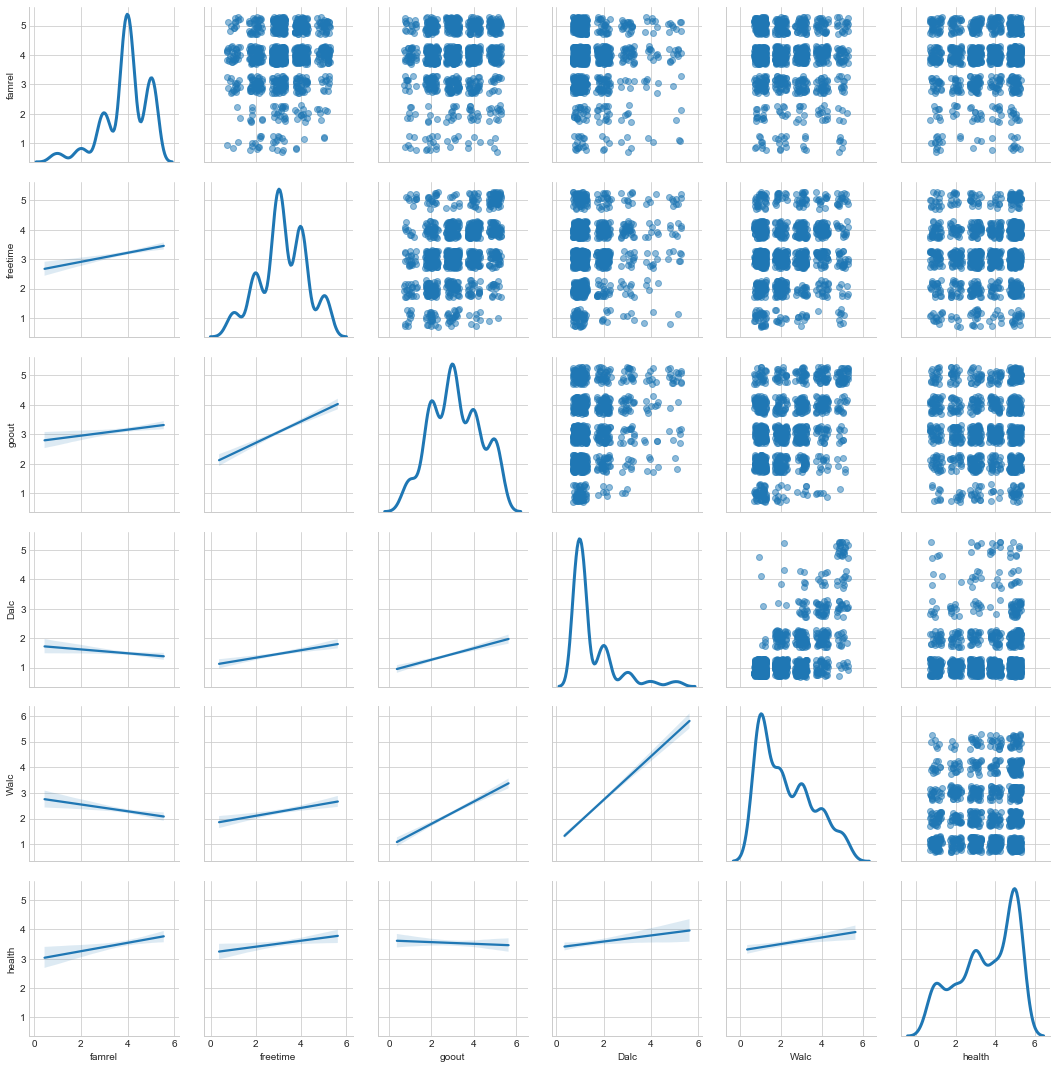

In [25]:
# Make the scatterplot matrix of the 1-5 scale items.
# We'll create a dataframe of random noise (or "jitter") and add it to the plot.

# Make a copy of the data to add jitter to and plot.
df_jittered = df.loc[:, 'famrel':'health']

# Make the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)

# Combine the data and the noise.

df_jittered = df_jittered.add(jitter)
#Declare the plot and plot.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

Finally, we'll inspect all the numerical variables together. The resulting plot is crowded and rather difficult to read, so it is simply there for the analyst to get oriented with the data.

/Users/teresaoneill/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


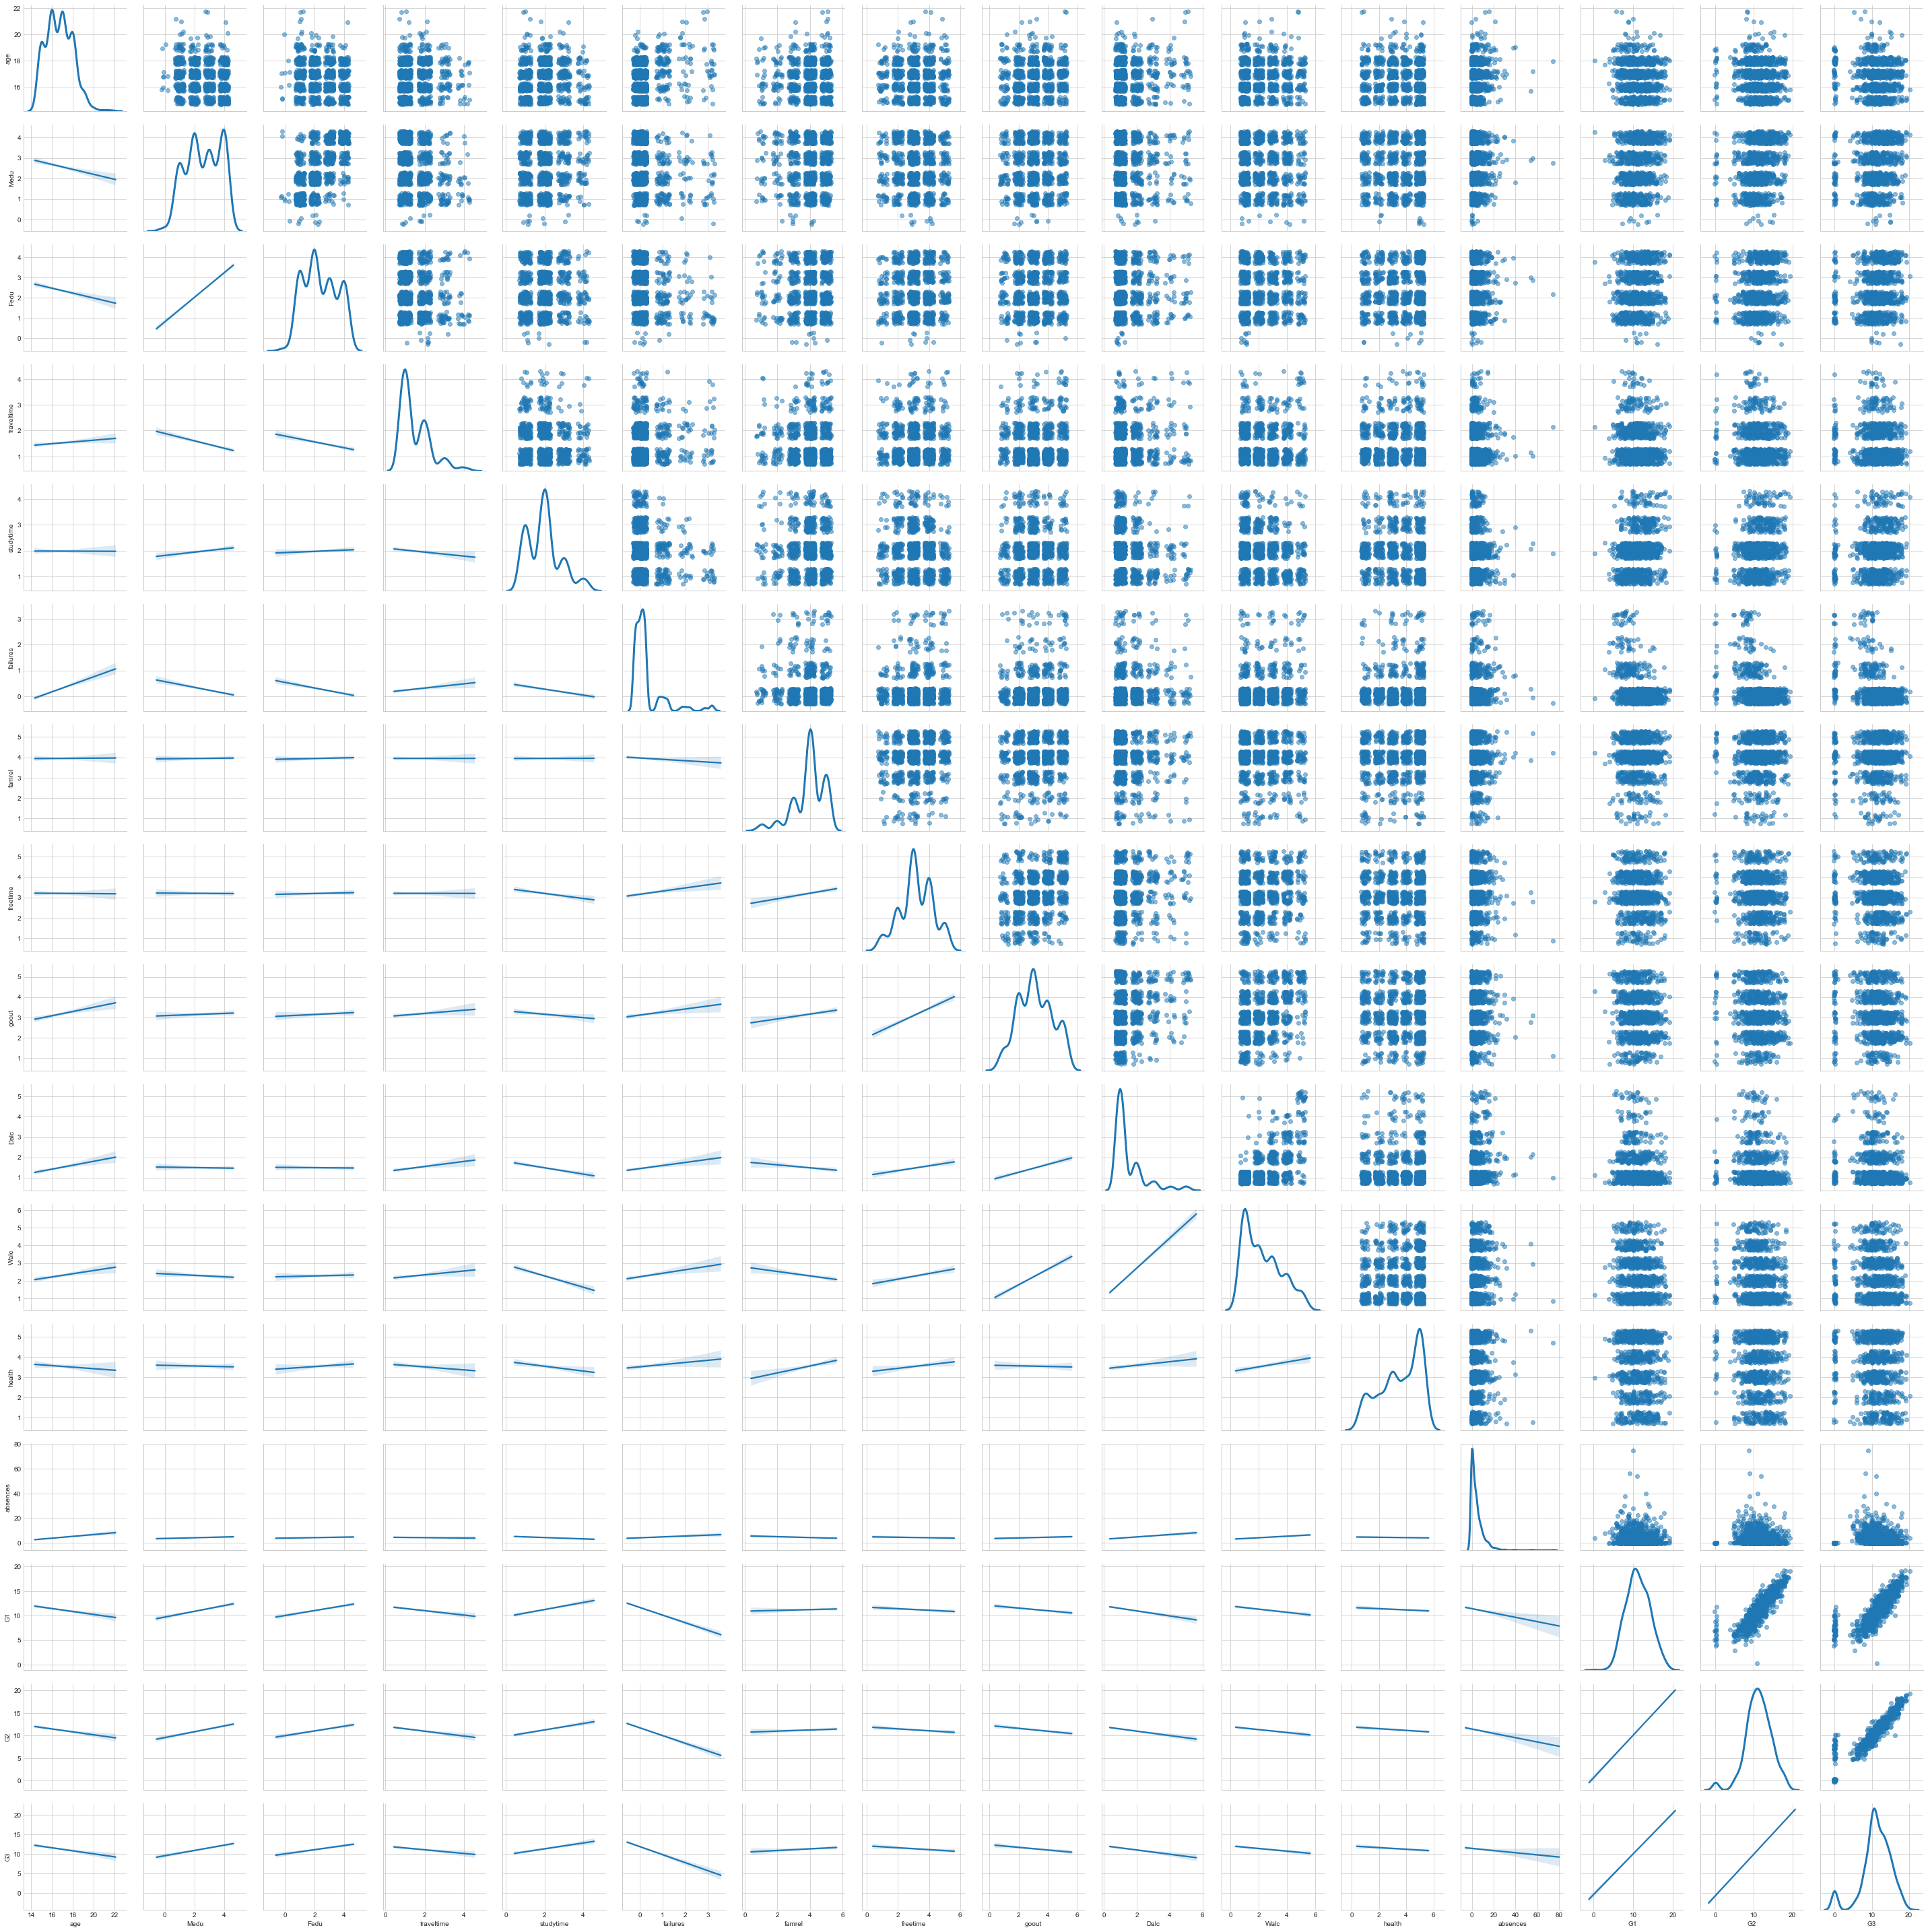

In [26]:
df_num = df.select_dtypes(include=[np.number])

df_jittered = df_num.dropna()

# Make the random noise.
jitter = pd.DataFrame(
    np.random.uniform(-.3, .3, size=(df_jittered.shape)),
    columns=df_jittered.columns
)

# Combine the data and the noise.

df_jittered = df_jittered.add(jitter)
#Declare the plot and plot.
g = sns.PairGrid(df_jittered.dropna(), diag_sharey=False)
g.map_upper(plt.scatter, alpha=.5)

# Fit line summarizing the linear relationship of the two variables.
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

# Give information about the univariate distributions of the variables.
g.map_diag(sns.kdeplot, lw=3)
plt.show()

A complete correlation matrix of the 16 variables, visualized with a heatmap, will help to identify relevant features for the model.

                 age      Medu      Fedu  traveltime  studytime  failures  \
age         1.000000 -0.130196 -0.138521    0.049216  -0.007870  0.282364   
Medu       -0.130196  1.000000  0.642063   -0.238181   0.090616 -0.187769   
Fedu       -0.138521  0.642063  1.000000   -0.196328   0.033458 -0.191390   
traveltime  0.049216 -0.238181 -0.196328    1.000000  -0.081328  0.087177   
studytime  -0.007870  0.090616  0.033458   -0.081328   1.000000 -0.152024   
failures    0.282364 -0.187769 -0.191390    0.087177  -0.152024  1.000000   
famrel      0.007162  0.015004  0.013066   -0.012578   0.012324 -0.053676   
freetime    0.002645  0.001054  0.002142   -0.007403  -0.094429  0.102679   
goout       0.118510  0.025614  0.030075    0.049740  -0.072941  0.074683   
Dalc        0.133453  0.001515 -0.000165    0.109423  -0.159665  0.116336   
Walc        0.098291 -0.029331  0.019524    0.084292  -0.229073  0.107432   
health     -0.029129 -0.013254  0.034288   -0.029002  -0.063044  0.048311   

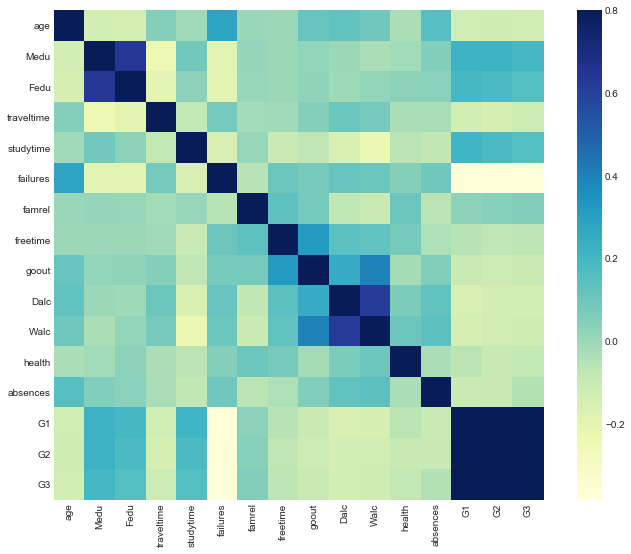

In [27]:
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True, cmap="YlGnBu")
plt.show()

Turning now to the categorical variables, we will focus on a subset of the binary features, including gender, family educational support, home internet acccess, and extracurricular activities. 

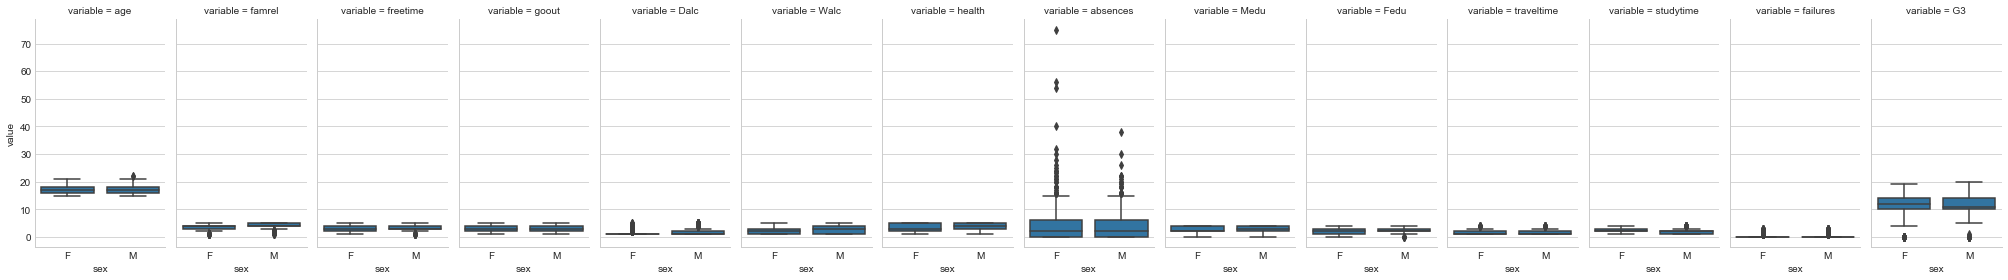

In [28]:
#Check for outliers and differences between the sexes.
#It would be great to break this into rows for easier visualization, but I haven't succeeded.

df_long1 = pd.concat([df.loc[:, 'sex':'age'], df.loc[:, 'famrel':'absences'], df['Medu'], df['Fedu'], df['traveltime'], df['studytime'], df['failures'], df['G3']], axis=1)
df_long1melt = pd.melt(df_long1, id_vars=['sex'])

g = sns.FacetGrid(df_long1melt, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "sex", "value")
plt.show()

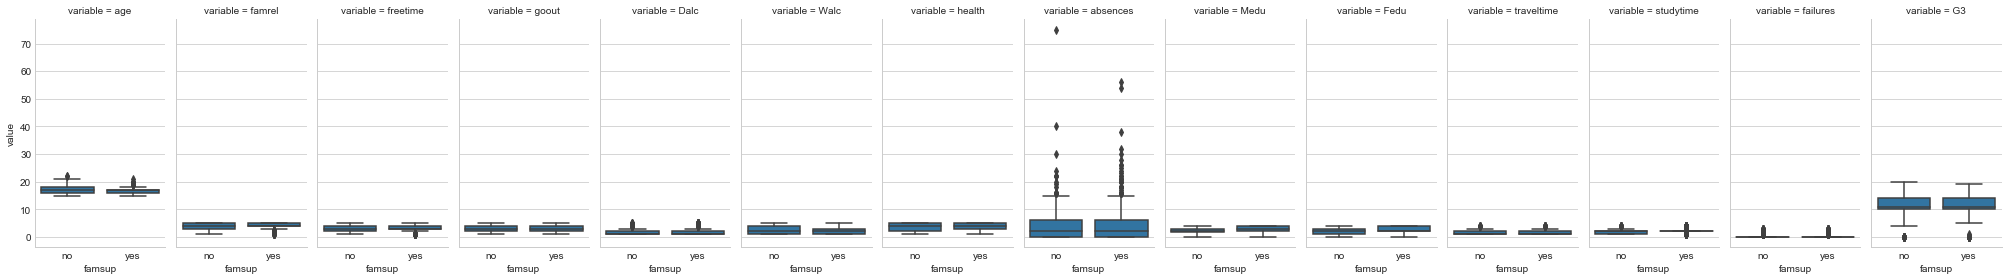

In [29]:
#Check for outliers and differences between those with and without family support.

df_long2 = df_long1.drop(['sex'], axis=1)
df_long2 = pd.concat([df_long2, df['famsup']], axis=1)

df_long2melt = pd.melt(df_long2, id_vars=['famsup'])

g = sns.FacetGrid(df_long2melt, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "famsup", "value")
plt.show()

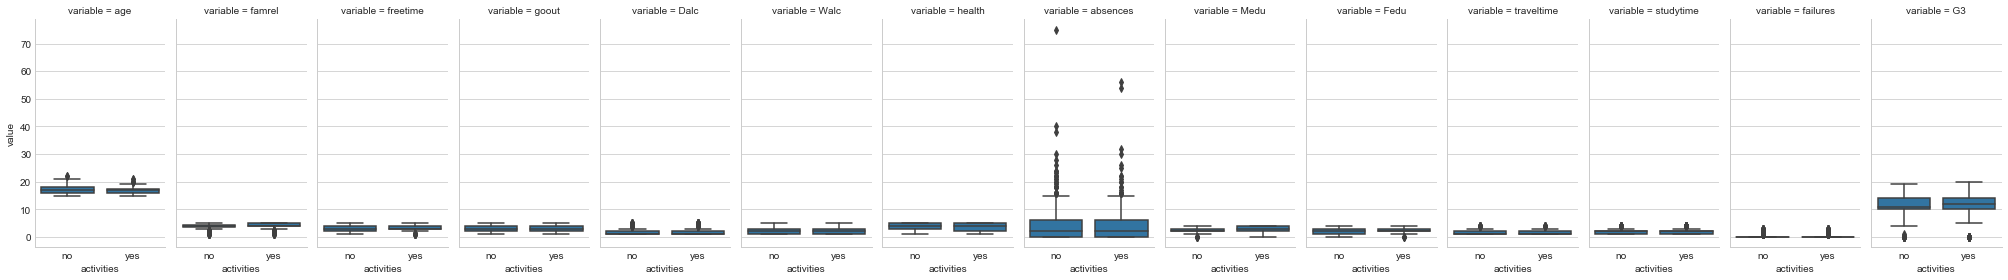

In [30]:
#Check for outliers and differences w.r.t. extracurricular activities.

df_long3 = df_long2.drop(['famsup'], axis=1)
df_long3 = pd.concat([df_long3, df['activities']], axis=1)

df_long3melt = pd.melt(df_long3, id_vars=['activities'])

g = sns.FacetGrid(df_long3melt, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "activities", "value")
plt.show()

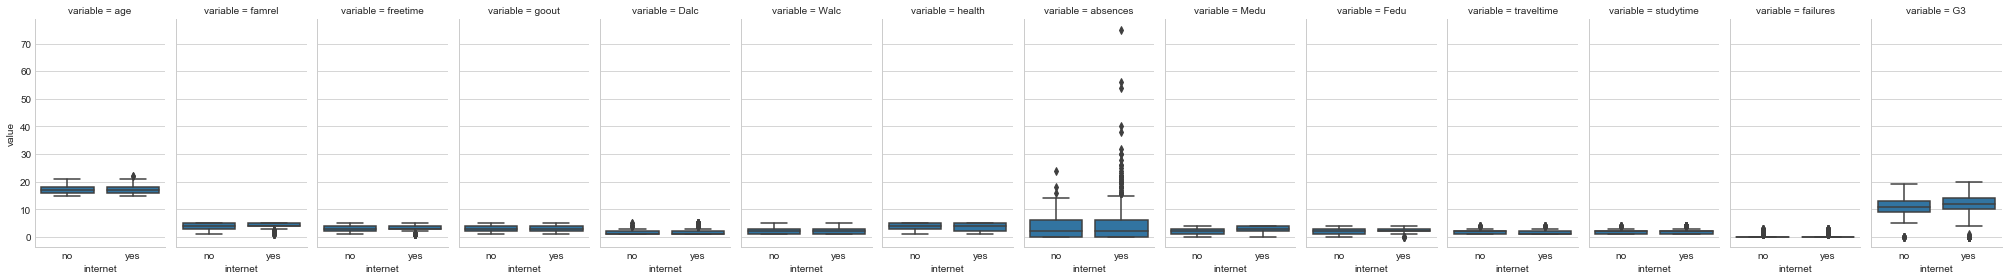

In [31]:
#Check for outliers and differences w.r.t. home internet.

df_long4 = df_long3.drop(['activities'], axis=1)
df_long4 = pd.concat([df_long4, df['internet']], axis=1)

df_long4melt = pd.melt(df_long4, id_vars=['internet'])

g = sns.FacetGrid(df_long4melt, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "internet", "value")
plt.show()

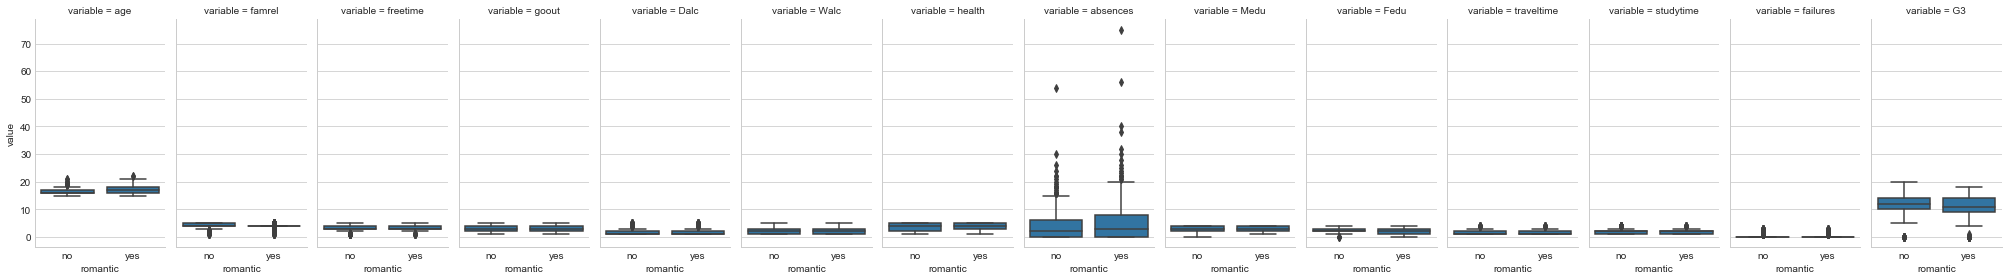

In [32]:
#Check for outliers and differences w.r.t. romantic relationships.

df_long5 = df_long4.drop(['internet'], axis=1)
df_long5 = pd.concat([df_long5, df['romantic']], axis=1)

df_long5melt = pd.melt(df_long5, id_vars=['romantic'])

g = sns.FacetGrid(df_long5melt, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "romantic", "value")
plt.show()

In [33]:
# Test whether group differences are significant.
print("SEX")
for col in df_long1.loc[:,'age':'G3'].columns:
    print(col)
    print(stats.ttest_ind(
        df_long1[df_long1['sex'] == 'F'][col].dropna(),
        df_long1[df_long1['sex'] == 'M'][col].dropna()
    ))
    
print("FAMILY SUPPORT")
for col in df_long2.loc[:,'age':'G3'].columns:
    print(col)
    print(stats.ttest_ind(
        df_long2[df_long2['famsup'] == 'yes'][col].dropna(),
        df_long2[df_long2['famsup'] == 'no'][col].dropna()
    ))
    
print("EXTRACURRICULUARS")
for col in df_long3.loc[:,'age':'G3'].columns:
    print(col)
    print(stats.ttest_ind(
        df_long3[df_long3['activities'] == 'yes'][col].dropna(),
        df_long3[df_long3['activities'] == 'no'][col].dropna()
    ))
    
print("INTERNET ACCESS")
for col in df_long4.loc[:,'age':'G3'].columns:
    print(col)
    print(stats.ttest_ind(
        df_long4[df_long4['internet'] == 'yes'][col].dropna(),
        df_long4[df_long4['internet'] == 'no'][col].dropna()
    ))
    
print("ROMANTIC RELATIONSHIP")
for col in df_long5.loc[:,'age':'G3'].columns:
    print(col)
    print(stats.ttest_ind(
        df_long5[df_long5['romantic'] == 'yes'][col].dropna(),
        df_long5[df_long5['romantic'] == 'no'][col].dropna()
    ))

SEX
age
Ttest_indResult(statistic=1.2544501972842119, pvalue=0.20995973022764383)
famrel
Ttest_indResult(statistic=-2.4188846003078832, pvalue=0.015738662363410091)
freetime
Ttest_indResult(statistic=-5.9612903507465731, pvalue=3.421756733192959e-09)
goout
Ttest_indResult(statistic=-2.0224368938719453, pvalue=0.043386307114516402)
Dalc
Ttest_indResult(statistic=-9.2667012728597271, pvalue=1.0689688107448257e-19)
Walc
Ttest_indResult(statistic=-10.249265955183168, pvalue=1.4967429276561518e-23)
health
Ttest_indResult(statistic=-4.6011629841489627, pvalue=4.7180545063801947e-06)
absences
Ttest_indResult(statistic=0.42211748588870768, pvalue=0.67302634291858721)
Medu
Ttest_indResult(statistic=-3.5523247089172876, pvalue=0.00039892955869104169)
Fedu
Ttest_indResult(statistic=-2.290728110779563, pvalue=0.022178122889967671)
traveltime
Ttest_indResult(statistic=-1.3733972174097817, pvalue=0.16992431914102141)
studytime
Ttest_indResult(statistic=7.9794641563179907, pvalue=3.854655632592829e-1

Based on the plots and t-tests, we can see that 'absences' has many outliers, which could pose a problem for the analysis. We will adjust for this later by splitting 'absences' into a binary categorical variable. 

We can also see that there are a two binary variables for which our outcome variable (final grade) significantly differs: home internet access and romantic relationships. Let's take these two variables and look for interactions with the others in their effect on final grades.

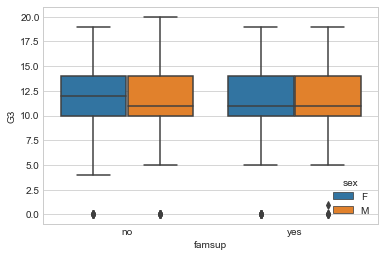

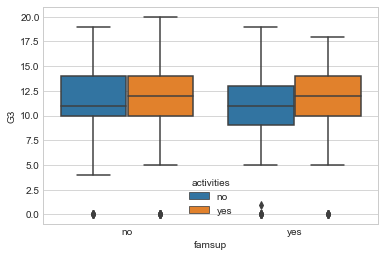

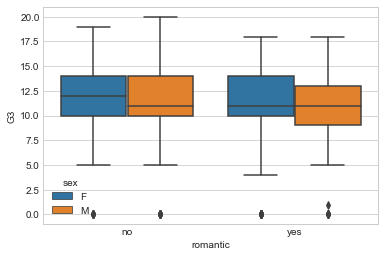

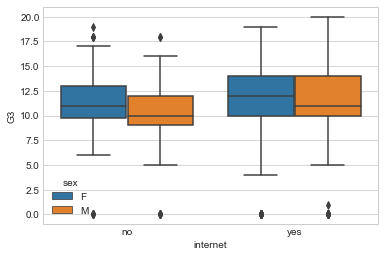

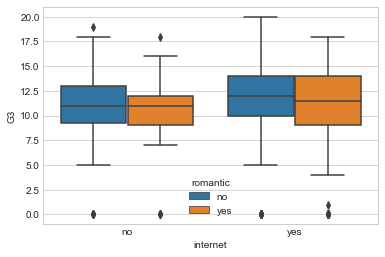

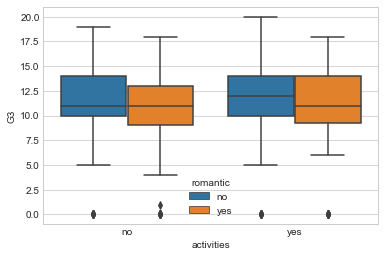

In [34]:
# Look at interactions.
sns.boxplot(y="G3", x='famsup', hue="sex", data=df)
plt.show()

# Look at interactions.
sns.boxplot(y="G3", x='famsup', hue="activities", data=df)
plt.show()

# Look at interactions.
sns.boxplot(y="G3", x='romantic', hue="sex", data=df)
plt.show()

# Look at interactions.
sns.boxplot(y="G3", x='internet', hue="sex", data=df)
plt.show()

# Look at interactions.
sns.boxplot(y="G3", x='internet', hue="romantic", data=df)
plt.show()

# Look at interactions.
sns.boxplot(y="G3", x='activities', hue="romantic", data=df)
plt.show()

One observation stemming from the boxplots above is that there is an interaction between students' gender and participation in romantic relationships with respect to final grade: female students in romantic relationships have lower grades than those who are not in romantic relationships, while the difference appears to be smaller for male students.

### Feature engineering

To create our set of ten features, let's start with the scalar variables that we plotted as continuous variables above. 

**Feature 1: Attendance**

For the 'absences' variable, we can clearly see that the right skew in the distributions makes it amenable to being treated as a categorical factor. Let's get a descriptions to decide where to split it. 

In [35]:
print(df['absences'].describe())

count    1044.000000
mean        4.434866
std         6.210017
min         0.000000
25%         0.000000
50%         2.000000
75%         6.000000
max        75.000000
Name: absences, dtype: float64


The description of this variables gives us more insight into the right-skewed distribution. We can easily split this into a categorical factor using thresholds inspired by the mean. This will give us (roughly) evenly sized groups that meaningfully capture the difference between students with excellent attendance (0 or 1 absence), those with middling attendance (2-4 abstences) and those with poor attendance (more than 5 absences). 

(A binary split would've been fine too--I'm just playing with new techniques.)

In [36]:
features = pd.DataFrame()

features['absentee'] = np.where(df['absences']>=5, 2, (np.where(df['absences']<=1, 1, 0)))

# Check to make sure it worked.
print(df['absences'].groupby(features['absentee']).describe())
print(df['G3'].groupby(features['absentee']).describe())


          count       mean       std  min  25%  50%   75%   max
absentee                                                       
0         336.0   2.913690  0.975058  2.0  2.0  2.0   4.0   4.0
1         374.0   0.040107  0.196473  0.0  0.0  0.0   0.0   1.0
2         334.0  10.886228  7.349629  5.0  6.0  8.0  12.0  75.0
          count       mean       std  min   25%   50%   75%   max
absentee                                                         
0         336.0  11.889881  2.759475  5.0  10.0  11.0  14.0  20.0
1         374.0  10.954545  5.151388  0.0  10.0  12.0  14.0  19.0
2         334.0  11.224551  2.985530  4.0   9.0  11.0  13.0  19.0


** Feature 2: Prior failures**

Most students have no prior failures, but a few do. Let's split this variable into a binary feature.

In [37]:
print(df['failures'].value_counts())

features['failures'] = np.where(df['failures']>0, 1, 0)

0    861
1    120
2     33
3     30
Name: failures, dtype: int64


** Feature 3: Alcohol consumption ** 

Next, we can look at the variables related to alcohol consumption (weekend drinking and weekday drinking). First of all, as the correlation matrix and heatmap showed, they are correlated with each other (r=0.63). Let's start by reducing them into one factor. 

In [38]:
#Select the two variables.
df_alc = df[['Dalc','Walc']]

#Normalize the variables.
X = StandardScaler().fit_transform(df_alc)

# Transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

#Run PCA analysis on the two variables
sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

features['Alc'] = Y_sklearn[:, 0]

Covariance Matrix:
 [[ 1.00095877  0.62841577]
 [ 0.62841577  1.00095877]]
The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.81390692  0.18609308]


Since the first component explains 81% of the variance, we can keep just the first component and discard the original two variables related to alcohol consumption. We'll store this component in our featureset, and later test it in our model.

** Feature 4: Drinker vs. Non-drinker**

Returning to the observation that the alcohol consumption variables are not normally distributed, it may be best to re-engineer these variables as binary categories: drinkers and non-drinkers. Let's take a look at the survey responses to decide where to split them. 

Later, during tuning and cross-validation, we'll test how well these different features fare in the model.

In [39]:
print(df['Dalc'].value_counts())
print(df['Walc'].value_counts())

features['day_drinker'] = np.where(df['Dalc']>=3, 1, 0)
features['weekend_drinker'] = np.where(df['Walc']>=3, 1, 0)

1    727
2    196
3     69
5     26
4     26
Name: Dalc, dtype: int64
1    398
2    235
3    200
4    138
5     73
Name: Walc, dtype: int64


** 5. Parental education **

Similarly, father's and mother's educational levels are highly correlated, so these can probably be collapsed into one feature 'parental education', especially since we can see that both are correlated with our outcome variable, final grade.

In [40]:
#Normalize the alcohol consumption variables.
df_par = df[['Fedu','Medu']]

#Normalize the variables.
X = StandardScaler().fit_transform(df_par)

# The NumPy covariance function assumes that variables are represented by rows,
# not columns, so we transpose X.
Xt = X.T
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

sklearn_pca = PCA(n_components=2)
sklearn_pca = sklearn_pca.fit(X)
Y_sklearn = sklearn_pca.transform(X)

#fit_transform applies both methods
#separate them so you can apply it on your test data
#save sklearn_pca after the first fit sklearn_pca.fit(X) is an inplace function; then transform (X)
#separately transform onto the training data, then onto the test data
#create a new feature based on the first vector of Y_sklearn

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

#Add the first component back to our featureset.
features['Paredu'] = Y_sklearn[:, 0]

Covariance Matrix:
 [[ 1.00095877  0.64267874]
 [ 0.64267874  1.00095877]]
The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [ 0.82103157  0.17896843]


Principal Components Analysis allows us to collapse mother's and father's education into a single component, parental education, which explains 82% of the variance of the original two components. 

** Feature 6+: Sex and relationship interaction **

Above, we observed that, while grades do not differ significantly based on sex, there is a difference for students who are in romantic relationships. A comparison of the two categorical variables strongly suggests that the difference is actually due to an interaction, so let's create a feature for this interaction.

In [41]:
#First, recode the categorical variables.

features['sex'] = np.where(df['sex'] == 'M', 1, 0)
features['romantic'] = np.where(df['romantic'] == 'yes', 1, 0)
features['internet'] = np.where(df['internet'] == 'yes', 1, 0)
features['activities'] = np.where(df['activities'] == 'yes', 1, 0)
features['famsup'] = np.where(df['famsup'] == 'yes', 1, 0)

#Add the interaction to the features dataframe. 
features['sex_relationship'] = features['sex'] * features['romantic']

** Feature 7: Commute time**

Currently, travel time is on a 1-4 scale where 4 is the maximum. Since long travel time is negatively correlated with time for other activities (e.g., study, extracurriculars), let's reverse the scale so that lower numbers indicate long commutes, and high numbers indicate short commutes.

In [42]:
features['commute'] = max(df['traveltime']) - df['traveltime']

** Feature 8-10: Remaining continuous variables**
    
Let's add our remaining numerical variables to the feature set.

In [43]:
df_num = df.select_dtypes(include=[np.number]).dropna()

# Save the column names.
names=df_num.columns

# Scale, then turn the resulting numpy array back into a data frame with the
# correct column names.
df_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names)


In [44]:
features = pd.concat([features, df.loc[:, 'famrel':'goout'], df['health'], df['age'], df['studytime'], df['G3']], axis=1)

### Feature selection

Now, let's use a filter to select the five features that are most closely correlated with the outcome variable. 

Ultimately, our feature selection procedure will be governed by the cross-validation process, since we do not yet know which features will perform best.

In [45]:
corrs = features.corr().values
corrmat = features.corr()
print(corrmat)
#ranks = (features.columns[:-1][-corrs[:-1,-1].argsort()]).tolist()
#print(ranks)
#features.head()

                  absentee  failures       Alc  day_drinker  weekend_drinker  \
absentee          1.000000  0.111169  0.129094     0.116659         0.094925   
failures          0.111169  1.000000  0.123435     0.116400         0.087437   
Alc               0.129094  0.123435  1.000000     0.755724         0.767856   
day_drinker       0.116659  0.116400  0.755724     1.000000         0.400340   
weekend_drinker   0.094925  0.087437  0.767856     0.400340         1.000000   
Paredu           -0.017578  0.212841  0.002586    -0.000099         0.003139   
sex              -0.000319  0.048772  0.320645     0.244505         0.243930   
romantic          0.101702  0.089314  0.016008     0.012510        -0.016609   
internet          0.051815 -0.068062  0.046070     0.015858         0.045554   
activities       -0.045466 -0.042570 -0.002388    -0.016786         0.011223   
famsup           -0.001900 -0.037158 -0.053134    -0.062519        -0.060194   
sex_relationship  0.050964  0.064107  0.

Relying on a simple filter based on correlations between each feature and the outcome variable, we can reduce our feature set to:

- prior failures
- parental education
- study time
- drinking
- age

When we model, we'll examine the full set of features, and adjust the featureset according to the results of crossvalidation.